# [Hull] Basic Approach and new feature（日本語/Eng） #  

今回のお題は、100近い特徴量をもとに米国の代表的な株価指数であるS&P500への毎日の最適な投資配分を予測するというものです。  
まずは基本的なアプローチをおこないベースラインを決めたうえで、特徴量を操作してどの程度Public Scoreが改善するか試してみたいと思います。  
注意すべきは、以下のDiscussion(※1)でも言われている通り、Leader Boardがあてにならないということでしょう。これはこのコンペの公式説明(※2)でも言われています。Public Scoreが良すぎるのは過学習の結果である、ということのようなので、いったんこの見解に従い、Public Score 3.0以下でなるべくスコアが良くなるように色々試してみたいと思います。Leader Boardが良くならないように頑張るというのも珍しいですね（笑）  

特徴量を操作してみた結果は以下の通りです。  
なかなか思う通りにPublic Scoreが伸びませんでしたが、特徴量「V7」を10日間分Rollingして纏めてみるとスコアが良化するという興味深い結果になりました。  

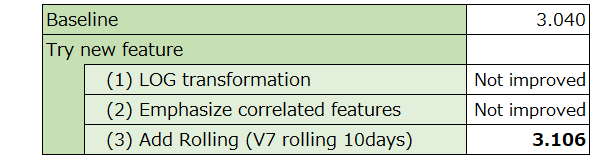

This competition is to predict the optimal daily investment allocation for the S&P 500, which is a leading U.S. stock index, based on nearly 100 features.
First, I'd like to establish a baseline using a basic approach, then, to experiment with feature manipulation to see how much the Public Score improves.
A key point to note, as mentioned in the Discussion(※1) below, is that the Leader Board is meaningless. This is also stated in the official competition description(※2). Since a too high Public Score likely means overfitting, we will tentatively follow this view and experiment with various approaches to achieve the best possible score while keeping the Public Score at or below 3.0.   
It's quite interesting to be working hard to keep the Leader Board score low, isn't it? (lol)  

The result of various feature engineering effort is as above chart.  
Public Score wasn't improved as much as hoped, but, an interesting result emerged: rolling the feature “V7” with 10 days improved the score.   


(※1）　https://www.kaggle.com/competitions/hull-tactical-market-prediction/discussion/608088  

(※2)　Quoted from Dataset Description of this competition
The test set used for the public leaderboard set is a copy of the last 180 date IDs in the train set. As a result, the public leaderboard scores are not meaningful.

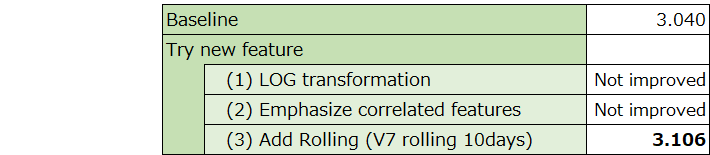
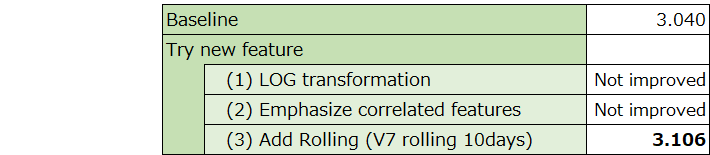
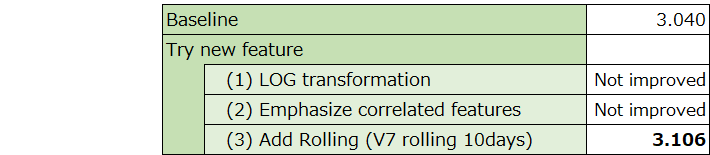
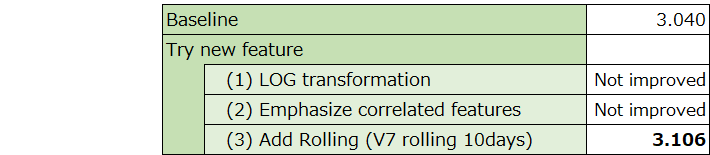
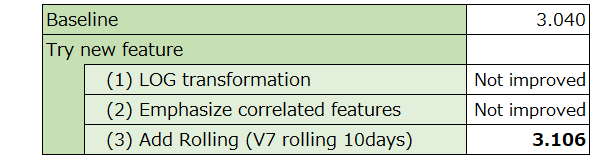
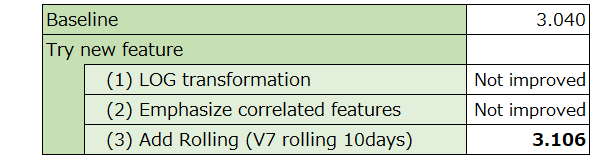
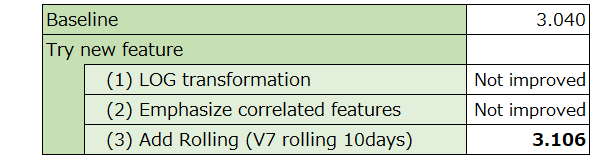

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
import os
import polars as pl

pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')
df_train

## (1) Simply throw Training data into LGBM ##  

まずは、何も考えずにTrain Dataを単純にLightGBMに投入してみます。
Sbmission Fileの公式説明に「you must predict an optimal allocation of funds to holding the S&P500」とあるので、予測対象は厳密にはS&P500を保有する資金割合なのですが、便宜上、yデータはとりあえず「market_forward_excess_returns」をセットします。  
以下のコードはを実行するとPublic Scoreは**4.640**といきなり高得点が出てしまいます。  
（実際にSubmitしないよう一部コメントアウトしています）  

First, let's simply feed the Train Data into LightGBM as it is.  
The submission file in official explanation states “you must predict an optimal allocation of funds to holding the S&P500,” so strictly speaking, the prediction target is the fund allocation for investing the S&P500. However, for convenience, I'll set “market_forward_excess_returns” as y-data for now.
If you Run the code below, you'll see **4.640**, which is higher than our expectation from the beginning.  
(Some parts are commented-out to prevent actual submission)

In [ ]:
all_cols = df_train.columns
non_use_cols = ['date_id','forward_returns','risk_free_rate','market_forward_excess_returns']
feature_cols = [col for col in all_cols if col not in non_use_cols]

"""
y = df_train['market_forward_excess_returns'].copy()
X = df_train[feature_cols]

model_lgbm = lgbm.LGBMRegressor(
        objective="regression",        
        random_state = 42,
        verbose = -1,
        n_estimators=300 )
model_lgbm.fit(X, y)

import kaggle_evaluation.default_inference_server

def predict(test_df):    
    test_df = test_df.to_pandas()    
    test = test_df[feature_cols]   
    pred = model_lgbm.predict(test)   
    allocation = pred    
    allocation = np.clip(allocation, 0.0, 2.0)
    return float(allocation)
    
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))
"""

## (2) Prepare Baseline ##

何も考えずにLightGBMに投入するだけで、いきなり目標としていたPublic Score3.0を上回る高得点がでてしまいましたが、これには2つの理由が考えられます。

一つは、コンペのData Descriptionの説明に記載されているように、Test DataはTrain Dataの一部であること。正解が含まれているTrain Dataで学習すれば高得点が出るのは当たり前ですね。

I simply fed the data into LightGBM and immediately achieved a score exceeding my target Public Score of 3.0. I think there are two possible reasons for this.

First, as stated in the competition's Data Description, the Test Data is mere a subset of the Train Data. It's quite natural to achieve a high score when training using Train Data which already contains the correct answers.  

QUOTE-----------------  
The test set used for the public leaderboard set is a copy of the last 180 date IDs in the train set. As a result, the public leaderboard scores are not meaningful  
UNQUOTE---------------  

ということで、まずはTrain DataからTest Dataを除外します。コンペの説明を見ますと、トレーニングフェーズはTrain Dataの最後の180レコードがTest Dataということなのですが、予測フェーズで使われるTestデータは「about the same size」ということで必ずしも180レコードとは限らないようです。  
なので、Test Dataの「is_scored」がTrueになっているレコードをTrain Dataから取り除くことにします。  
これにより、Public Scoreは**4.640→2.660**へと下がりますが、これでもまだ少し高いですね。

So, you need to exclude the Test Data from the Train Data.  
According to the competition description, the Test Data during the training phase is the last 180 records of the Train Data. However, the Test Data used during the prediction phase is described as “about the same size,” so it doesn't seem the actual Test data will be exactly 180 records.  
Therefore, I'd like to remove records from the Train Data where the “is_scored” field in the Test Data is set to True.  
This causes the Public Score to drop from **4.640 to 2.660**, but it's still a bit high.

In [ ]:
remov_row_df = df_test[df_test['is_scored'] == True]
remov_row = remov_row_df['date_id'].to_list()
df_train = df_train[~df_train['date_id'].isin(remov_row)]

高いスコアが出た二つ目の理由としては、n_estimatorsを300にセットしていたことだと思われます。  
Train Dataは9000レコード程度のSmallなデータセットなので、300もセットすると過学習を起こしたものと思われます。ということでn_estimatorsを100にします。  
これにより、Public Scoreは**2.054**へと下がります。  

The second reason for the high score was likely setting n_estimators to 300.
Since the train data is a small dataset of about 9,000 records, setting it to 300 likely caused overfitting. Therefore, I'd like to set n_estimators to 100.
This reduces the public score to **2.054**.

In [ ]:
y = df_train['market_forward_excess_returns'].copy()
X = df_train[feature_cols]

model_lgbm = lgbm.LGBMRegressor(
        objective="regression",        
        random_state = 42,
        verbose = -1,
        n_estimators=100 ) #<-------------change frpm 300 to 100
model_lgbm.fit(X, y)

せっかくPublic Scoreを目標レベルまで落としたところですが、Submission対象を変える必要があります。  
今現在は、「market_forward_excess_returns」をyデータとして予測したPredを提出していますが、本来このコンペで予測するのはS&P500の資金配分（Allocation）です。  
以下のNotebookでPredをAllocationに変える手法が紹介されていたので参考にしてみました。  
正確な理屈は分かっていないので恐縮なのですが、Allocationをこれに変えるだけでPublic Scoreは**3.040**へと一気に上がりました。目標とする「Public Score 3.0」は超えてしまいますが、これは過学習の結果ではないので良しとします。この値をベースにして、特徴量の操作でスコアの改善を目指したいと思います。

As above, I have managed to lower the Public Score to the target level, but the submission target needs to be changed.  
Currently, I'm submitting a Pred that forecasts “market_forward_excess_returns” as y-data, but the actual target for prediction in this competition is the S&P 500 allocation.
I found a notebook below describing a method to switch the Pred to Allocation, so I tried it for now.  
I'm not necessarily sure of the exact reasoning behind this calculation, but simply changing the Allocation to this resulted in the Public Score jumping up to **3.040**.  This exceeds the target “Public Score 3.0”, but I'd like to accept it since it is not the result from overfitting.  
I'd plan to use this value as a baseline and aim to improve the score through feature engineering.

**Thanks to** : https://www.kaggle.com/code/dedquoc/htmp-baseline-eda-lightgbm-v1  
Convert prediction into allocation  
allocation = 1.0 + 50 * pred

## (3) Try LOG transformation (--> Not Improved) ##  

まずは、LightGBMが重視する上位の特徴量でヒストグラムが歪なポアソン分布になっているものがあれば、それを対数化することでPublic Scoreが改善するか調べてみます。  

First, if any of the top features which LightGBM regards important show skewed Poisson distributions in their histograms, we will investigate whether applying Log-transformation to them improves the Public Score or not.

In [ ]:
result = lgbm.plot_importance(model_lgbm, max_num_features=20, importance_type="split") 
plt.tight_layout()
plt.show()

In [ ]:
column_list =['M4','M3','E19','S2','P7','P3','P5','P6','V13','P13']
plt.figure(figsize=(20,20))
for i, column in enumerate(column_list) :
    plt.subplot(5, 5, i+1)
    plt.hist(df_train[f"{column}"], bins=100)
    plt.title(column)
plt.show

P6とV13が極端なポアソン分布になっているので、これらを以下のコードで対数化してみることでPublic Scoreの改善ができるか試してみます。  
結果は、ベースラインの**3.040**から**2.882**へと少し悪化しました。  
この手法はあまり有効ではないようです。  

Since P6 and V13 show extreme Poisson distributions, I'd like to try improving the Public Score by applying Log-transformation to them using the following code.  

The result slightly worsened from the baseline of **3.040 to 2.882**.  
This approach does not seem very effective.

In [ ]:
def change_log(df) :
    target_log = ['P6', 'V13'] 
    for i, column in enumerate(target_log) :
        df[f"{column}"] = np.log(df[f"{column}"])
    return df

#df_train = change_log(df_train)

## (4) Add new feature emphasizing correlated features (---> Not Improved) ##  

次に、相互に関係性のある特徴量を強調する新しい特徴量を追加することでスコアが改善するか試してみます。  
同じカテゴリー（EとE、VとV等）の特徴量同士が高い関係性を示すのはおかしくないので、異なるカテゴリーの特徴量間で高い関係性を示すものを探してみます。  

Next, we'll test whether scores improve by adding new features that emphasize mutually correlated features.
It's not unusual for features within the same category (E and E, V and V, etc) to show high correlation, thus, I'd like to look for features across different categories that show strong correlation.

In [ ]:
X_corr = X.corr()
import seaborn as sns
plt.figure(figsize =(50,50))
sns.heatmap(X_corr, vmax=1, vmin=-1, center=0, annot=True)

In [ ]:
V11_corr = X_corr['V11']
V11_corr_df = pd.DataFrame(V11_corr)
V11_corr_df.T

中央下部あたりのV11・M16が白色に近く高い関係性を示しています。  
ヒートマップの文字が小さくて見づらいので抜き出してみると、V11はM16と0.935もの高い関係性を示しています。  
この2つの特徴量を掛け合わせたものを、新しい特徴量として加えてみます。  
これをSubmitすると、Public Scoreは**2.977**となり、またもやベースラインの3.040を超えることは出来ませんでした。  
なかなか狙い通りにうまく行かないものですね。  

V11 and M16 near the center-bottom show a high correlation, appearing nearly white color.
The text on the heatmap is too small and hard to read, so let's extract it, then V11 somehow shows a quite high correlation of 0.935 with M16.  
I'd like to add a new feature by multiplying these two features together.  
Submitting this will result in a Public Score of **2.977**, once again failing to improve the baseline of 3.040.  
Things don't always go as planned.... (LoL)

In [ ]:
def add_feature(df) :
    df["V11M16"] = df["V11"] * df["M16"]
    return df
    
# df_train = add_feature(df_train)

## (5) Add new feature with rolling (--> Improved to 3.106) ##  

次に、特徴量を何日か前から纏めたものを新しい特徴量として加えてみます。  
そもそも、このコンペの案内には以下のような記載があり、「知られうる全ての情報は既に株価に織り込まれている」ことを検証することが一つの目的だと思います。

Next, I'd like to add a new feature that aggregates historical data from several days prior.
In the first place, the competition guidelines state the following, and I believe one objective is to verify that “all known information is already priced into the stock”

**QUOTED from Competition launch announcement** --------------  
The Efficient Market Hypothesis (EMH) would say everything knowable is already priced into a stock price. But how true is that theory?   
効率的市場仮説（EMH）によれば、知られうる全ての情報は既に株価に織り込まれている。しかし、この理論はどれほど真実なのか？  
UNQUOTE ---------------------

全ての特徴量をひとつずつ、当日までの5日分・10日分まとめたものを新たな特徴量として加え、スコアが改善するかどうかを確認したいと思います。  
ただ、特徴量は100個近くあり、毎回本当にSubmitするわけにもいかないので、LightGBMのスコアを見て改善しそうな特徴量を絞り込み、それらをSubmitしてPublic Scoreが改善するかどうかを見たいと思います。  
まずは、今のベースラインのLightGBMのスコアがどの程度なのかを見てみます。  

I'd like to add each feature individually as a new feature, combining 5 days' worth and 10 days' worth up to the current day, and check if the score improves.  
However, there are nearly 100 features, and I can't realistically submit them all each time. So, I plan to look at LightGBM's score to narrow down features which will likely improve it, submit those, and see if the Public Score improves.  

First, I'll check what the current baseline LightGBM score is.

In [ ]:
df_train_orig = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
    
all_cols = df_train_orig.columns
non_use_cols = ['date_id','forward_returns','risk_free_rate','market_forward_excess_returns']
feature_cols = [col for col in all_cols if col not in non_use_cols]
    
df_train = df_train_orig[:-10]
    
y = df_train['market_forward_excess_returns'].copy()
X = df_train[feature_cols]

model_lgbm = lgbm.LGBMRegressor(
        objective="regression",        
        random_state = 42,
        verbose = -1,
        n_estimators=100 )
model_lgbm.fit(X, y)

df_val = df_train_orig.tail(10)
X_test = df_val[feature_cols]
y_test = df_val['market_forward_excess_returns'].copy()
model_lgbm.score(X_test, y_test)

今のベースラインのLightGBMのスコアは約**0.095**なので、5日分・10日分まとめた新しい特徴量を加えて**0.100**を上回るものに絞り込みたいと思います。  
ただ、注意すべきは、このLightGBmスコアは、テストデータがわずか10レコードのものですし、実際にSubmitした時の評価とも異なるので、あくまで絞り込むための目安にしか使えません。  

これを理解したうえで、全ての特徴量（カテゴリーDのものは除外しています）を5日分・10日分まとめてLightGBMスコアを算出する簡易ツールを作ってみました。  
（ちょっと冗長なのでコードは非表示にしています。ご興味があれば開いて見てみてください）  

The current baseline LightGBM score is approximately 0.095, so I want to narrow down the features which will exceed 0.100 by adding new ones that combine 5 days' and 10 days' worth of data.  
However, please be reminded that this LightGBM score is based on a test dataset with only 10 records and differs from the actual evaluation after submission. Therefore, it should only be used just as a guideline for narrowing down features.  

With this understanding, I created a simple tool that calculates the LightGBM score by combining 5 days' worth and 10 days' worth of all features (excluding those in category D).

Code itself is hidden, so please open it if you are interested. 

In [ ]:
def func_rolling1(df, target, i) :        
    df['rolling_mean'] = df[f"{target}"].rolling(window=i).mean()
    return df

def autoscorer(target, i):
    df_train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
    df_test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')

    df_train = func_rolling1(df_train, target, i)
    df_test = func_rolling1(df_test, target, i)    
    
    all_cols = df_train.columns
    non_use_cols = ['date_id','forward_returns','risk_free_rate','market_forward_excess_returns']
    feature_cols = [col for col in all_cols if col not in non_use_cols]
    
    df_train = df_train[:-10]
    
    y = df_train['market_forward_excess_returns'].copy()
    X = df_train[feature_cols]

    model_lgbm = lgbm.LGBMRegressor(
        objective="regression",        
        random_state = 42,
        verbose = -1,
        n_estimators=100 )
    model_lgbm.fit(X, y)

    df_val = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
    df_val = df_val.tail(10) 
    df_val = func_rolling1(df_val, target, i)      
    X_test = df_val[feature_cols]
    y_test = df_val['market_forward_excess_returns'].copy()
    result = model_lgbm.score(X_test, y_test)

    return result

df_train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
non_use_corr = ['D1','D2','D3','D4','D5','D6','D7','D8','D9',
                'date_id','forward_returns','risk_free_rate','market_forward_excess_returns']
all_cols = df_train.columns
target_cols = [col for col in all_cols if col not in non_use_corr]

for i in (5, 10) :
    my_list = []
    better_score = []
    for col in target_cols:
        result = autoscorer(col, i)
        my_list.append([col,result])
        if result > 0.1 : 
            better_score.append([col, result])

    df = pd.DataFrame(my_list)
    df.columns = [f"{i}"' days rolling','score']
    display(df.T)
    df1 = pd.DataFrame(better_score)
    df1.columns = ['candidate','score']
    display(df1.T)

候補として抽出した９つ（5日間平均：E7, E8, M7, P3, P9, 10日間平均：M13, P7, S9, V7）を実際にSubmitしてみると、以下のような結果となりました。  

When I actually submitted the nine candidates extracted (5-day average: E7, E8, M7, P3, P9; 10-day average: M13, P7, S9, V7), I obtained the following results.

						
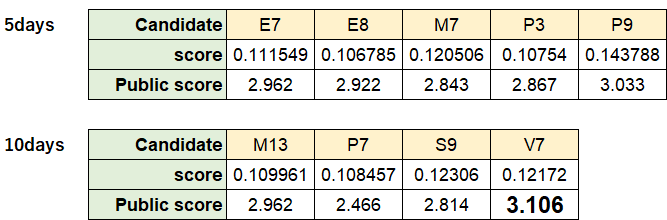
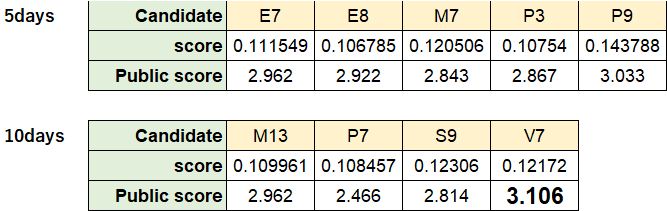
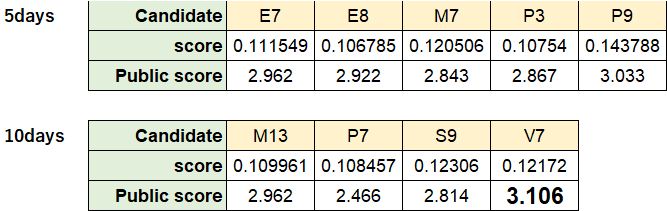
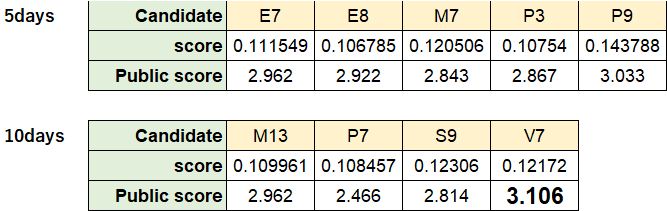
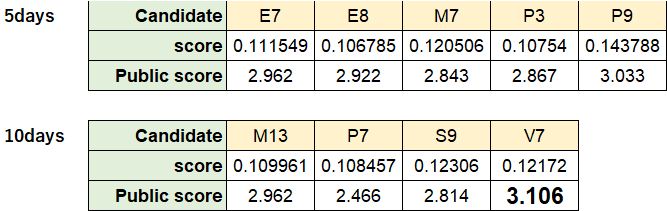
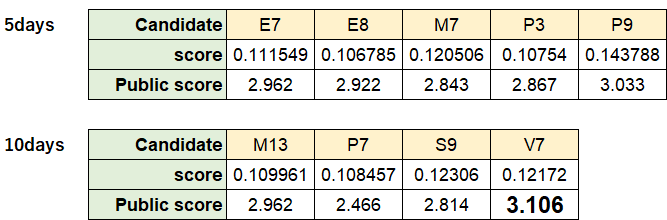
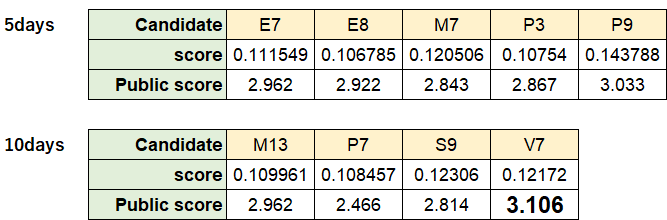
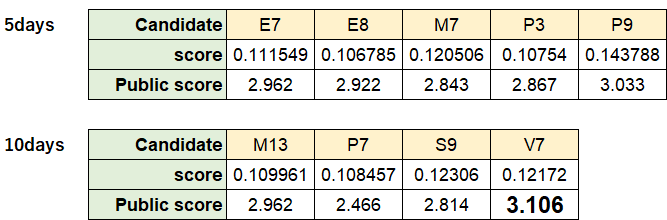

殆どの新特徴量はベースラインよりPublic Scoreが下がりましたが、唯一**V7**だけは10日間の平均を新特徴量に加えると**3.106**へとPublic Scoreが良化しました。  

これが何を意味するか考えてみます。 他のスコアが下がった特徴量は過去5日間・10日間の情報が株価に織り込まれているのでしょう（なので、それをわざわざ新特徴量として加えると逆にLightGBMにとっては学習の妨げとなる）。
逆に言うと、**V7**は過去10日間で見た情報は株価に**織り込まれていない**と言えるのかもしれません。  

Most new features resulted in a lower Public Score than the baseline. However, only **V7** showed an improvement in Public Score to **3.106** when the 10-day average was added as a new feature.  

Let's consider what this means. The features whose scores decreased likely reflect information from the past 5 or 10 days already being factored into the stock price (so adding this as a new feature actually hinders LightGBM's learning). Conversely, this may suggest that the information observed over the past 10 days for **V7** would **not yet be fully reflected** in the stock price.

## (6) Submission ##

これらの結果をまとめた最終コードは以下のようになります。  
目標としたPublic Score　**3.0以下**という目標は超えてしまいましたが、過学習ではなく特徴量操作の結果としてスコアが良化したものなので良しとしたいと思います。

The final code summarizing the avobe results is as follows.  
Although we exceeded the target Public Score of 3.0 or lower, I think this could be acceptable since the improved score resulted from feature engineering, not from overfitting.

In [ ]:
df_train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')

In [ ]:
def func_rolling(df) :          
    df['Averg'] = df['V7'].rolling(window=10).mean()
    return df
df_train = func_rolling(df_train)

In [ ]:
all_cols = df_train.columns
non_use_cols = ['date_id','forward_returns','risk_free_rate','market_forward_excess_returns']
feature_cols = [col for col in all_cols if col not in non_use_cols]

remov_row_df = df_test[df_test['is_scored'] == True]
remov_row = remov_row_df['date_id'].to_list()

df_train = df_train[~df_train['date_id'].isin(remov_row)]

In [ ]:
y = df_train['market_forward_excess_returns'].copy()
X = df_train[feature_cols]

In [ ]:
model_lgbm = lgbm.LGBMRegressor(
        objective="regression",        
        random_state = 42,
        n_estimators=100 )

model_lgbm.fit(X, y)

result = lgbm.plot_importance(model_lgbm, max_num_features=30, importance_type="split") 
plt.tight_layout()
plt.show()

In [ ]:
import os
import polars as pl
import kaggle_evaluation.default_inference_server

def predict(test_df):
    
    test_df = test_df.to_pandas()
    test_df = func_rolling(test_df)    
    test = test_df[feature_cols]    

    pred = model_lgbm.predict(test) 
    allocation = 1.0 + 50 * pred
    allocation = np.clip(allocation, 0.0, 2.0)

    return float(allocation)

inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))